In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
from env import get_db_url
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import wrangle_zillow
import scipy.stats as stats
alpha = .05
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

### What is driving the errors in the Zestimates?

Project Goal: 
- Determine drives of logerror within Zillow's model utilizing regression models. 
- Create clusters and explore data within them.
- Create a regression model that out performs Zillow's model when predicting log error.

Note* In the prior Zillow project, I asked for additional time to explore geographical impacts, this project will explore mostly location based clusters.


Initial Hypotheses:
- Log error depends on the geographic location. 
- Age, square feet, and tax value are related to log error.

Conclusions:
- Each geographic location has it's own features that drive log error.
- Polynomial regression model was able to outperform Zillow's model on 4 out of 7 counties.
- The best performing model was tested on a subset of a cluster- Region 5C.


### Acquire

- Zillow data was acquired from the Codeup database.
    - Query for single family homes with a transaction date in 2017.
- The original dataset was comprosied of 68 columns and 52,441 rows.

In [2]:
df = wrangle_zillow.get_zillow_data()

### Prepare

- Preparation steps include:
    - Removing columns and rows with more than 30% data missing.
    - Removed additional rows with null values.
    - IQR outlier function utilized    
    - Converted data types to integers
    - Labeled counties by name
    - Removed erroneous or duplicated columns
    - Created age, month_of_sale, taxvalue_per_sqft
    - Remaining data comprised of 15 columns and 33,660 rows


- Data dictionary
    - logerror (**target**)
    - bathroomcnt
    - bedroomcnt
    - calculatedfinishedsquarefeet
    - fips - converted to Orange, LA, and Ventura counties
    - latitude
    - longitude
    - lotsizesquarefeet
    - yearbuilt
    - taxvaluedollarcnt (tax appraised value)
    - transactiondate
    - propertylandusedesc
    - age(2017-yearbuilt)
    - taxvalue_per_sqft (calculatedfinishedsquarefeet/taxvaluedollarcnt)
    - month of sale

In [3]:
df = wrangle_zillow.prepare_zillow_data(df)

In [4]:
df.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale
0,3.5,4,3100,Orange,33634931,-117869207,4506,1998,1023282,0.025595,2017-01-01,Single Family Residential,19,330,1
2,2.0,3,1243,Orange,33886168,-117823170,8432,1962,564778,0.005383,2017-01-01,Single Family Residential,55,454,1
5,1.0,2,738,Los_Angeles,34149214,-118239357,4214,1922,218552,0.101723,2017-01-01,Single Family Residential,95,296,1


In [5]:
# split data into train, validate, test datasets
train, validate, test = wrangle_zillow.split_zillow_data(df)

### Explore

#### Questions to ask:
   - Is log error dependent on county?
   - Are log error and tax value related?
   - Are log error and square feet related?
   - Are log error and tax value per square feet related?
   - Are log error and age related?

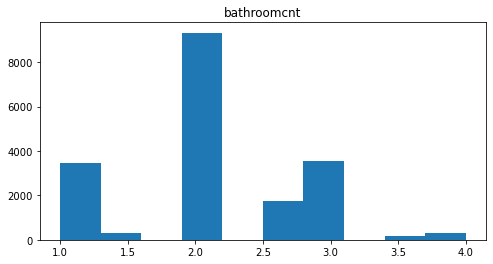

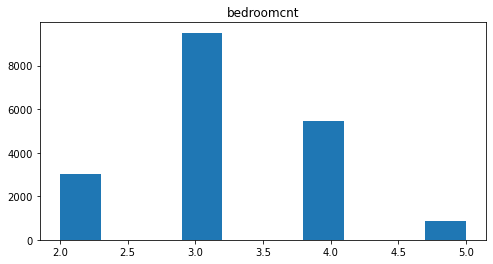

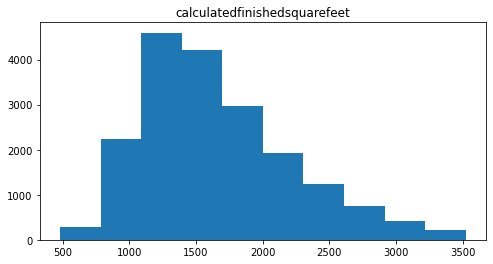

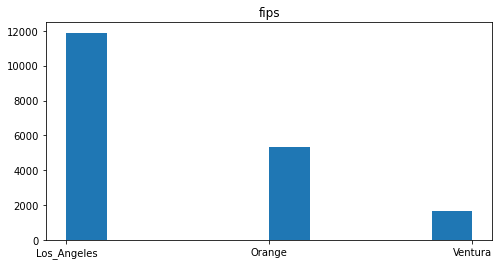

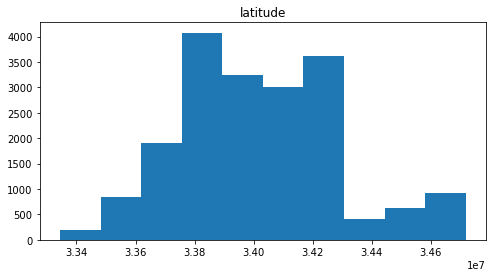

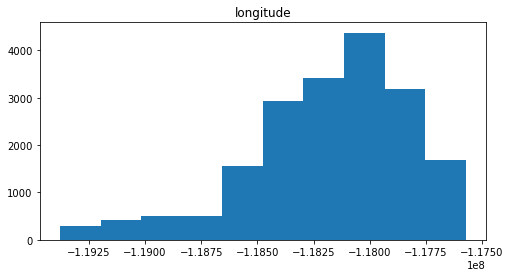

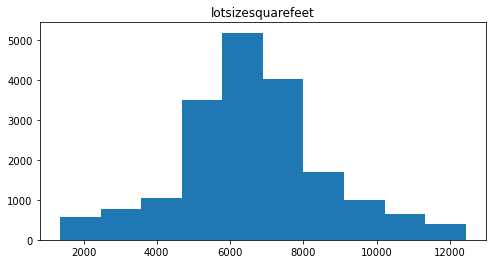

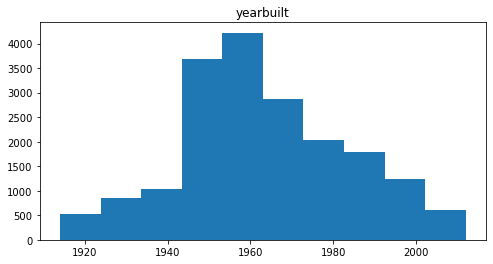

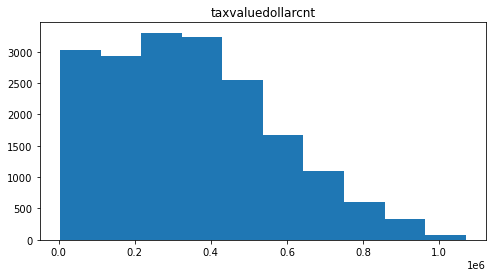

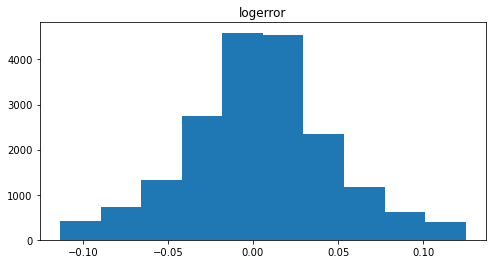

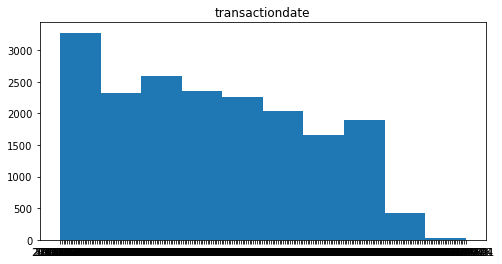

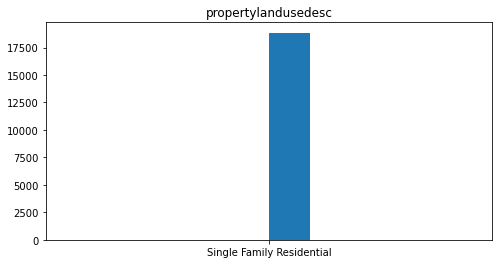

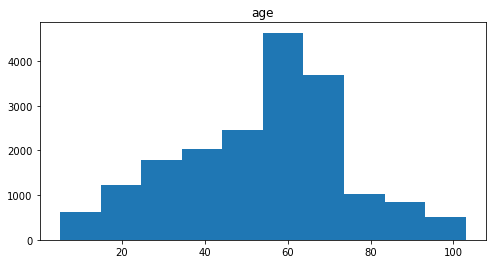

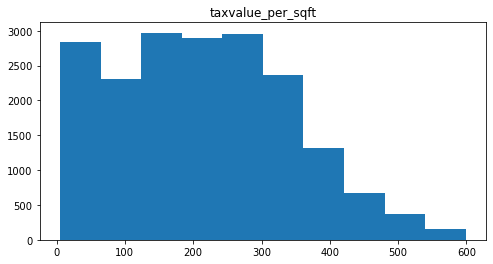

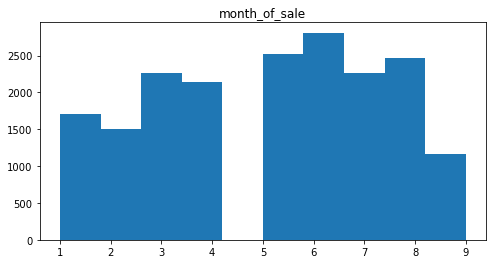

In [6]:
#create histograms for each column (utilized when deciding on appropriate hypothesis testing)
for col in train.columns:
    plt.figure(figsize=(8,4))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### Log error and county

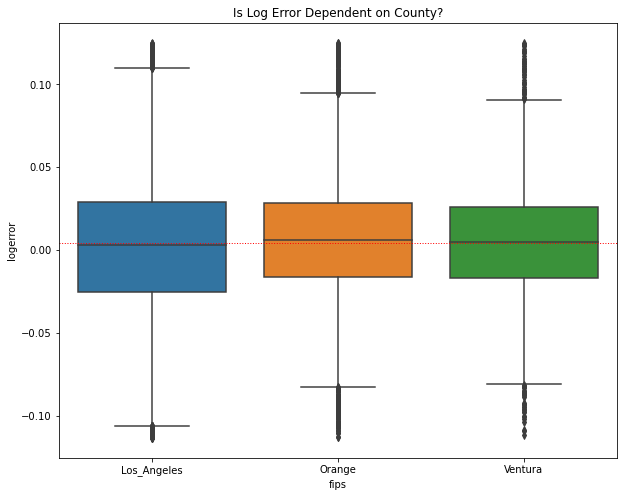

In [7]:
plt.figure(figsize=(10,8))
plt.title("Is Log Error Dependent on County?")
plt.axhline(train.logerror.median(),ls= ':', color = 'red', linewidth=1)
sns.boxplot(x=train.fips, y=train.logerror)
plt.show()

**Takeaway for visualization:**
- Los Angeles County's median logerror is more closely aligned with the population's log error, while Orange and Ventura County appear to have a greater median log error.

Next step:
- Perform hypothesis testing to determine if there is a difference in each county and the population mean.

- Null Hypothesis: The mean logerror of LA County is >= than the population mean.
- Alternative Hypothesis: The mean logerror of LA County is < than the population mean.

In [8]:
t, p = stats.ttest_1samp(train[train.fips=='Los_Angeles'].logerror.mean(), train.logerror.mean())

t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")


We reject the null hypothesis.


- Null Hypothesis: The mean logerror of Ventura County is <= than the population mean.
- Alternative Hypothesis: The mean logerror of Ventura County is > than the population mean.

In [9]:
t, p = stats.ttest_1samp(train[train.fips=='Ventura'].logerror.mean(), train.logerror.mean())
t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


- Null Hypothesis: The mean logerror of Orange County is <= than the population mean.
- Alternative Hypothesis: The mean logerror of Orange County is > than the population mean.

In [10]:
t, p = stats.ttest_1samp(train[train.fips=='Orange'].logerror.mean(), train.logerror.mean())
t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


**Notes: We can conclude, with statistical significance, that the means of the logerror of each county are not equal. LA County's logerror is less than the population, while Orange and Ventura counties' logerror means are greater than the population mean.**

### Log error and tax value

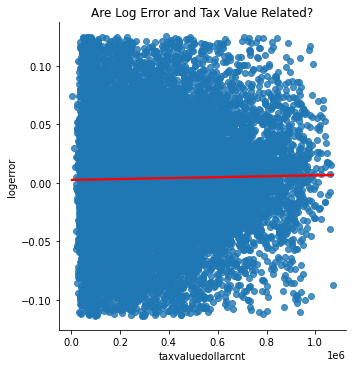

In [11]:
sns.lmplot(data=train, x='taxvaluedollarcnt',y='logerror',line_kws={'color':'red'})
plt.title("Are Log Error and Tax Value Related?")
plt.show()

- Null Hypothesis: There is no linear correlation between tax value and log error.
- Alternative Hypothesis: There is a lonear correlation between tax value and log error.

In [12]:
# perform correlation testing on taxvaluedollar count and logerror
alpha=.05
corr, p = stats.spearmanr(train.taxvaluedollarcnt, train.logerror)
p < alpha, corr, p

(True, 0.01500189594050002, 0.03943540885960506)

**Reject the null hypothesis.**
There is a very weak positive correlation.

### Log error and square feet

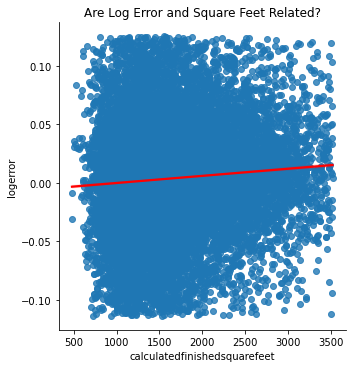

In [13]:
sns.lmplot(data=train, x='calculatedfinishedsquarefeet',y='logerror',line_kws={'color':'red'})
plt.title("Are Log Error and Square Feet Related?")
plt.show()

In [14]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(train.calculatedfinishedsquarefeet, train.logerror)
p < alpha, corr, p

(True, 0.07844755708028653, 4.003996331739839e-27)

**Reject the null hypothesis.** While weak, this is the strongest correlation with log error.

### Log error and tax value per square feet

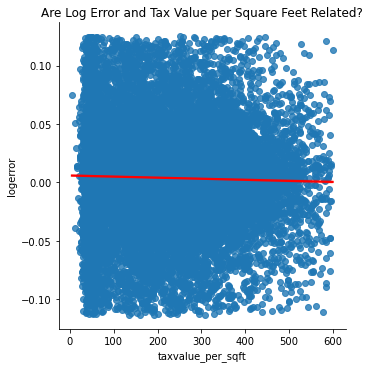

In [15]:
sns.lmplot(data=train, x='taxvalue_per_sqft',y='logerror',line_kws={'color':'red'})
plt.title("Are Log Error and Tax Value per Square Feet Related?")
plt.show()

In [16]:
# perform correlation testing on taxvaluepersqft count and logerror
alpha=.05
corr, p = stats.spearmanr(train.taxvalue_per_sqft, train.logerror)
p < alpha, corr, p

(True, -0.026686864469764683, 0.0002480222445226254)

**Reject the null hypothesis.** There is a weak negative correlation.

### Log error and age

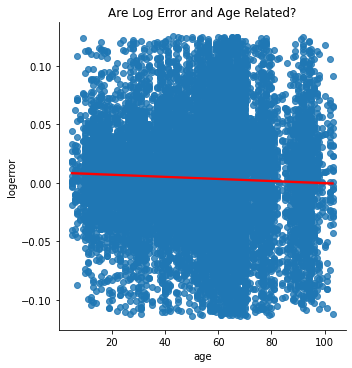

In [17]:
sns.lmplot(data=train, x='age',y='logerror',line_kws={'color':'red'})
plt.title("Are Log Error and Age Related?")
plt.show()

In [18]:
# perform correlation testing on taxvaluepersqft count and logerror
alpha=.05
corr, p = stats.pearsonr(train.age, train.logerror)
p < alpha, corr, p

(True, -0.04201049550159269, 7.933964116653264e-09)

**Reject the null hypothesis.** There is a weak negative correlation.

### Answers to questions:
- Log error differs by county.
- Log error increases as tax values increases.
- Log error decreases as the home of the age increases.
- **Log error increases as the size of the home increases.**
- Log error decreases as the tax value per square feet increases.
- There is a relationship between log error and latitude and longitude.

- The strongest correlation with log error is square feet, followed by age, latitude, tax value per square feet, longitude, and tax value.


### Clustering

#### Clustering by latitude/longitude

In [19]:
train_scaled, validate_scaled, test_scaled = wrangle_zillow.scale_data(train,validate,test)

In [20]:
X_train = train_scaled[['latitude','longitude']]
X_validate = validate_scaled[['latitude','longitude']]
X_test = test_scaled[['latitude','longitude']]

In [21]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_train)

kmeans.predict(X_train)
kmeans.predict(X_validate)
kmeans.predict(X_test)

array([4, 1, 4, ..., 5, 5, 0], dtype=int32)

In [22]:
train_scaled['clusters_by_lat_long'] = kmeans.predict(X_train)
validate_scaled['clusters_by_lat_long'] = kmeans.predict(X_validate)
test_scaled['clusters_by_lat_long'] = kmeans.predict(X_test)

Text(0.5, 1.0, 'K-Means Clusters')

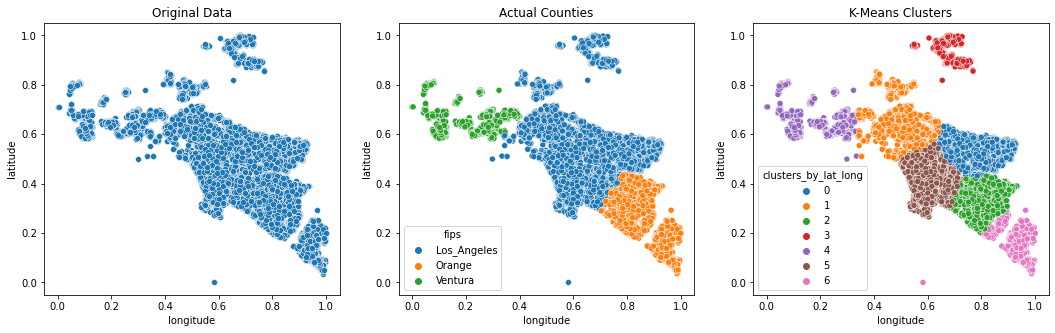

In [23]:
plt.figure(figsize=(18,5))
plt.subplot(131)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude')
plt.title('Original Data')

plt.subplot(132)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude', hue = 'fips')
plt.title('Actual Counties')

plt.subplot(133)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude', hue = 'clusters_by_lat_long', palette = ('tab10'))
plt.title('K-Means Clusters')

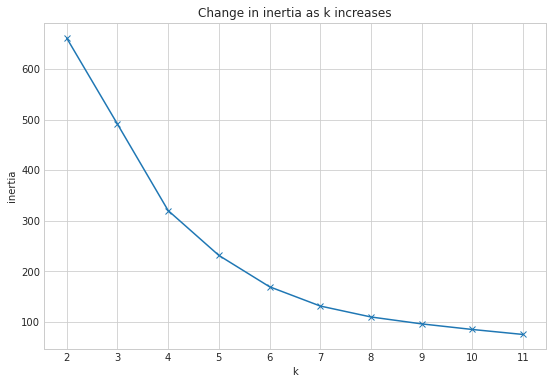

In [24]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- Prior exploration shows that each county has a different mean/median log error.
- **With locational clustering we can divide the 3 counties into 7 regions and may be better able to predict log error.**


### Further exploration within clusters

#### Questions to ask:
   - Is log error dependent on the region?
   - What is the relationship between log error and square feet, in each region?
   - What is the relationship between log error and age, in each region?

In [25]:
# Assign Region identifiers to clusters
def map_clusters(df):
    # identified counties for fips codes 
    clusters = {0: 'Region 1',
                 1: 'Region 2',
                 2: 'Region 3',
                 3: 'Region 4',
                 4: 'Region 5',
                 5: 'Region 6',
                 6: 'Region 7'}
     # map clusters 
    df.clusters_by_lat_long= df.clusters_by_lat_long.map(clusters)
    return df

In [26]:
map_clusters(train_scaled)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale,clusters_by_lat_long
51081,1.000000,0.666667,0.775477,Los_Angeles,0.582710,0.819429,0.288785,1.000000,0.513521,0.033457,2017-09-11,Single Family Residential,0.000000,0.318182,1.000,Region 1
28594,0.333333,0.333333,0.469099,Los_Angeles,0.607354,0.426485,0.557161,0.469388,0.097540,0.072372,2017-06-01,Single Family Residential,0.530612,0.085859,0.625,Region 2
30300,0.333333,0.666667,0.238988,Orange,0.195123,0.930407,0.532057,0.520408,0.276134,0.010291,2017-06-09,Single Family Residential,0.479592,0.405724,0.625,Region 7
14377,0.333333,0.333333,0.489152,Los_Angeles,0.518610,0.812801,0.835651,0.428571,0.357859,0.037286,2017-03-29,Single Family Residential,0.571429,0.319865,0.250,Region 1
4809,0.333333,0.333333,0.289941,Los_Angeles,0.369741,0.633546,0.374932,0.510204,0.043084,0.065184,2017-02-01,Single Family Residential,0.489796,0.052189,0.125,Region 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45872,0.000000,0.000000,0.180802,Los_Angeles,0.317690,0.593940,0.429836,0.285714,0.451379,-0.041453,2017-08-17,Single Family Residential,0.714286,0.782828,0.875,Region 6
39201,0.500000,0.666667,0.506903,Ventura,0.629864,0.196524,0.156312,0.928571,0.579743,0.019592,2017-07-17,Single Family Residential,0.071429,0.508418,0.750,Region 5
43571,0.500000,1.000000,0.981262,Ventura,0.676295,0.318738,0.628860,0.877551,0.557602,0.028175,2017-08-08,Single Family Residential,0.122449,0.281145,0.875,Region 5
14114,0.333333,0.333333,0.432939,Los_Angeles,0.462202,0.809191,0.688008,0.551020,0.143921,-0.032558,2017-03-28,Single Family Residential,0.448980,0.138047,0.250,Region 1


In [27]:
Region_1 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 1']
Region_2 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 2']
Region_3 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 3']
Region_4 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 4']
Region_5 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 5']
Region_6 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 6']
Region_7 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 7']
Region_8 = train_scaled[train_scaled.clusters_by_lat_long == 'Region 8']

**Visualize distribution of log error by region.**

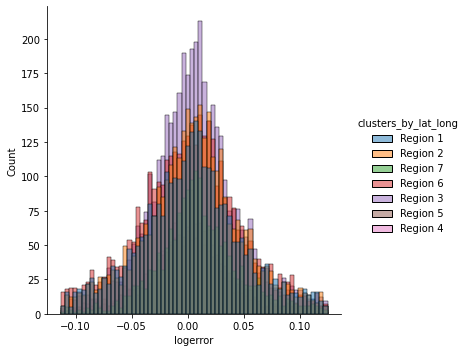

In [28]:
sns.displot(data=train_scaled,x='logerror', hue ='clusters_by_lat_long', palette=('tab10'))

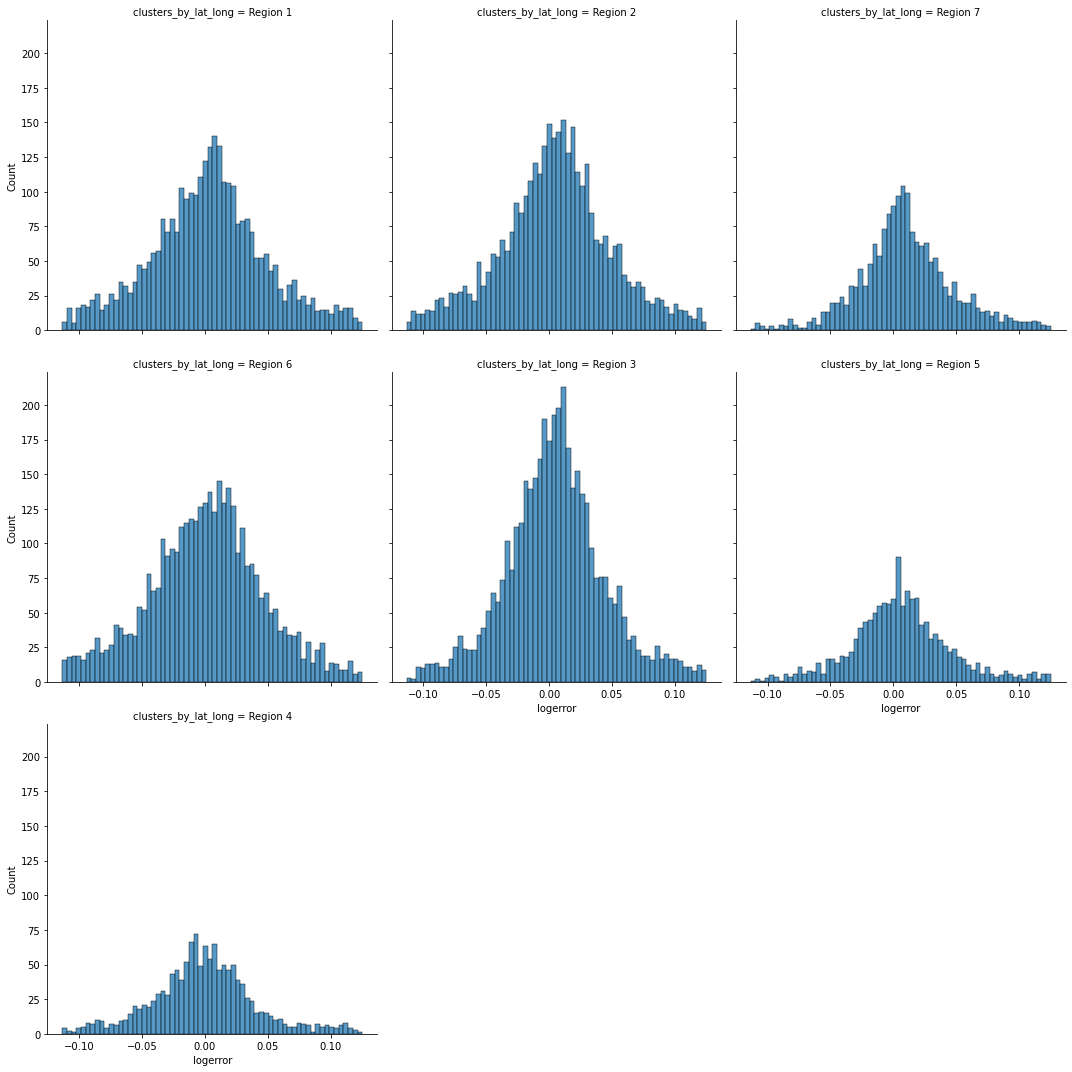

In [29]:
sns.displot(data=train_scaled,x='logerror', col ='clusters_by_lat_long', col_wrap =3)

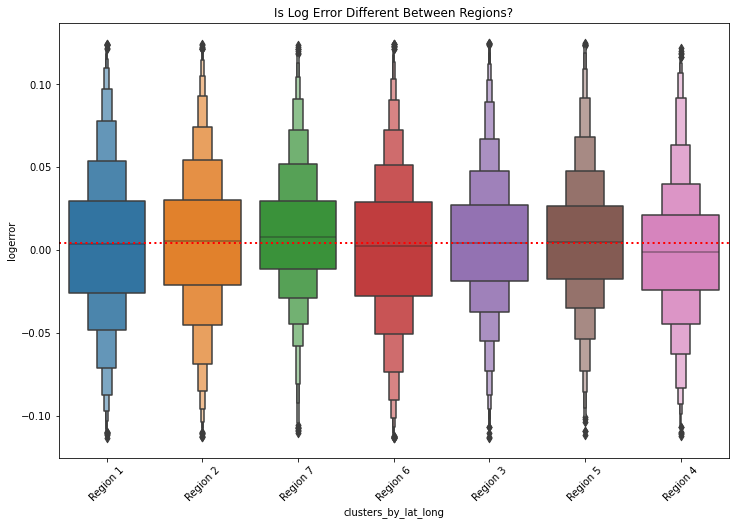

In [30]:
plt.figure(figsize=(12,8))
sns.boxenplot(data=train_scaled,x='clusters_by_lat_long',y='logerror')

plt.title("Is Log Error Different Between Regions?")
plt.xticks(rotation=45)
plt.axhline(train_scaled.logerror.median(),ls= ':', color = 'red', linewidth=2)
plt.show()

### Log Error and Square Feet by Region

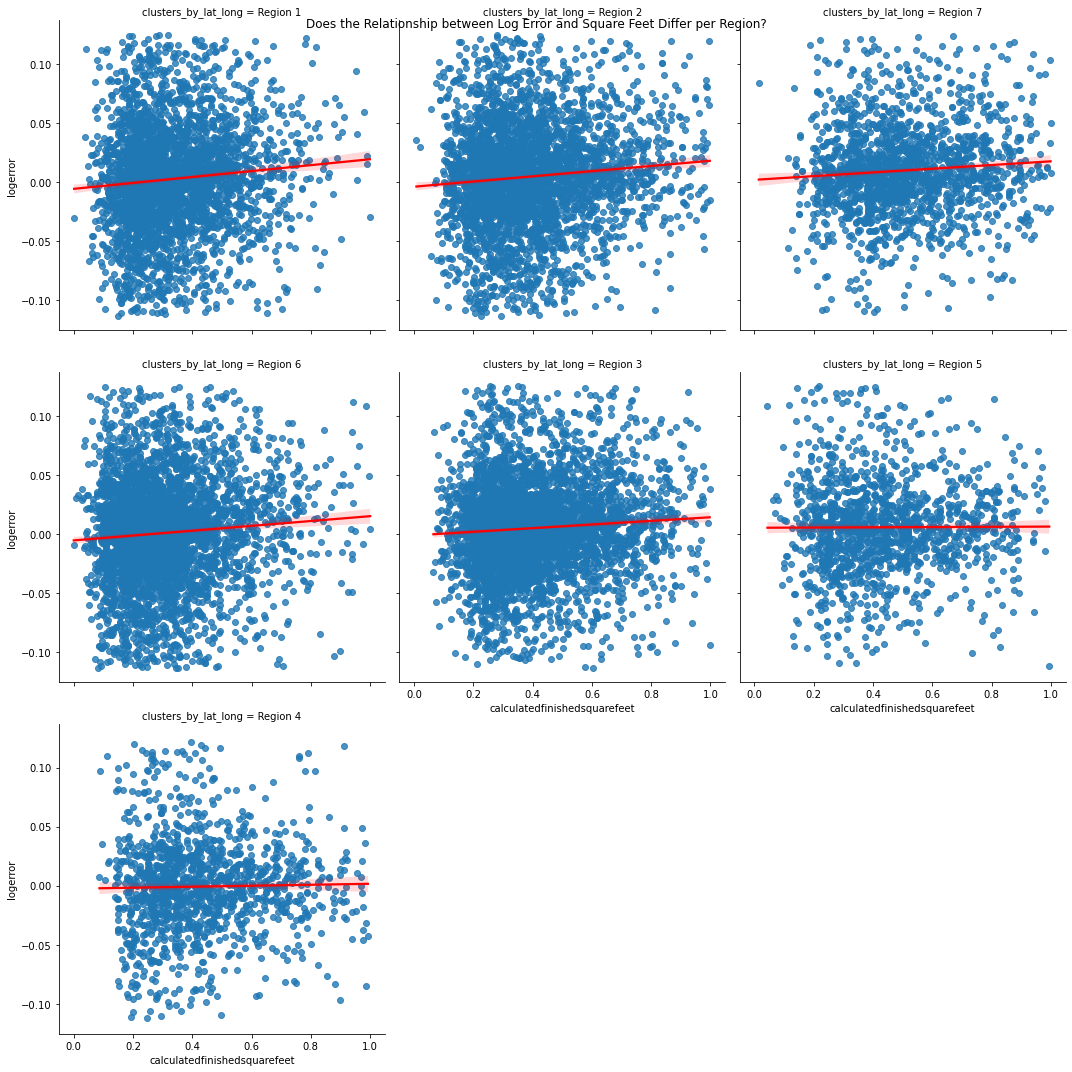

In [31]:
# visualize the linear relationship of log error and square feet by region
sns.lmplot(data=train_scaled,x='calculatedfinishedsquarefeet',y='logerror', col='clusters_by_lat_long', col_wrap=3, line_kws={'color':'red'})
plt.suptitle("Does the Relationship between Log Error and Square Feet Differ per Region?")
plt.show()

**Perform correlation hypothesis testing**
- Null Hypothesis: There is no linear relationship between log error and square feet.
- Alternative Hypothesis: There is a linear relationship between log error and square feet.

In [32]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(Region_1.calculatedfinishedsquarefeet, Region_1.logerror)
p < alpha, corr, p

(True, 0.08587603590523109, 1.4419835927563196e-06)

In [33]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(Region_2.calculatedfinishedsquarefeet, Region_2.logerror)
p < alpha, corr, p

(True, 0.07634465524873997, 6.270111989930051e-06)

In [34]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(Region_3.calculatedfinishedsquarefeet, Region_3.logerror)
p < alpha, corr, p

(True, 0.0678100398045093, 1.3588360006041277e-05)

In [35]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(Region_4.calculatedfinishedsquarefeet, Region_4.logerror)
p < alpha, corr, p

(False, 0.04439355821013524, 0.10639511234003031)

In [36]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(Region_5.calculatedfinishedsquarefeet, Region_5.logerror)
p < alpha, corr, p

(False, 0.017041388164050587, 0.5291466398087105)

In [37]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(Region_6.calculatedfinishedsquarefeet, Region_6.logerror)
p < alpha, corr, p

(True, 0.06582977024074219, 6.343114028481942e-05)

In [38]:
# perform correlation testing on square feet and logerror
alpha=.05
corr, p = stats.spearmanr(Region_7.calculatedfinishedsquarefeet, Region_7.logerror)
p < alpha, corr, p

(True, 0.07913422237866166, 0.0009835434427663348)

**Notes:**
- We reject the null hypothesis in all regions, except for region four and five.
- Correlation values range from .064 to .087.
- Each region has it's own correlation values, meaning that selecting different features per region could lead to better results.

### Log Error and Age by Region

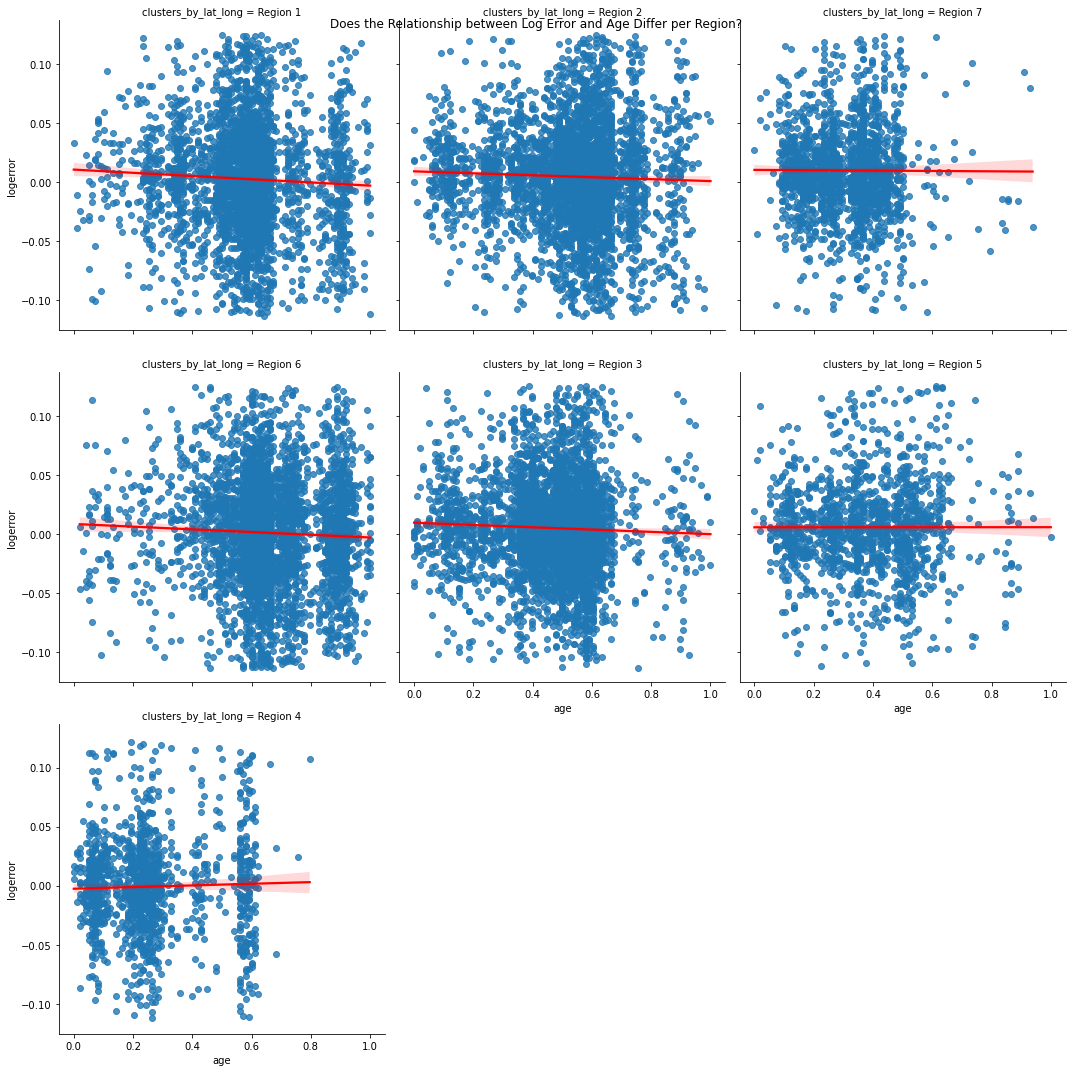

In [39]:
sns.lmplot(data=train_scaled,x='age',y='logerror', col='clusters_by_lat_long', col_wrap=3, line_kws={'color':'red'})
plt.suptitle("Does the Relationship between Log Error and Age Differ per Region?")
plt.show()

In [40]:
# perform correlation testing on age and logerror
alpha=.05
corr, p = stats.spearmanr(Region_1.age, Region_1.logerror)
p < alpha, corr, p

(True, -0.05563119290217049, 0.001817699157978016)

In [41]:
# perform correlation testing on age and logerror
alpha=.05
corr, p = stats.spearmanr(Region_2.age, Region_2.logerror)
p < alpha, corr, p

(False, -0.02503823262814348, 0.13900617668336754)

In [42]:
# perform correlation testing on age and logerror
alpha=.05
corr, p = stats.spearmanr(Region_3.age, Region_3.logerror)
p < alpha, corr, p

(True, -0.049874684269507634, 0.0013835609764621044)

In [43]:
# perform correlation testing on age and logerror
alpha=.05
corr, p = stats.spearmanr(Region_4.age, Region_4.logerror)
p < alpha, corr, p

(False, 0.0034899099468259425, 0.8990455565883058)

In [44]:
# perform correlation testing on age and logerror
alpha=.05
corr, p = stats.spearmanr(Region_5.age, Region_5.logerror)
p < alpha, corr, p

(False, 0.00025989002590165553, 0.9923431418590889)

In [45]:
# perform correlation testing on age and logerror
alpha=.05
corr, p = stats.spearmanr(Region_6.age, Region_6.logerror)
p < alpha, corr, p

(True, -0.05034477767182843, 0.0022322420992406996)

In [46]:
# perform correlation testing on age and logerror
alpha=.05
corr, p = stats.spearmanr(Region_7.age, Region_7.logerror)
p < alpha, corr, p

(False, -0.009585710472173367, 0.6902341613702818)

**Notes:**
- There is only a statistically significant linear correlation in regions one, three, and six.
- Correlation values are around .05.

### Modeling
- Initial modeling performed on scaled, training data.
    - Polynomial Regression with 3 degrees chosen for further modeling.
    - Modeling performed on age and square feet for all regions.
        - With additional time, explore different features per each region.
- RMSE used to evaulate the models.

In [47]:
X_train = train_scaled.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_train = train_scaled['logerror']

X_validate = validate_scaled.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_validate = validate_scaled['logerror']

X_test = test_scaled.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_test = test_scaled['logerror']

### Establish the baseline

In [48]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [49]:
# 1. Predict LE_pred_mean
LE_pred_mean = y_train['logerror'].mean()
y_train['LE_pred_mean'] = LE_pred_mean
y_validate['LE_pred_mean'] = LE_pred_mean

In [50]:
# 2. compute LE_pred_median
LE_pred_median = y_train['logerror'].median()
y_train['LE_pred_median'] = LE_pred_median
y_validate['LE_pred_median'] = LE_pred_median

In [51]:
# RMSE of LE_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

RMSE using Mean
Train/In-Sample:  0.04270227238364972 
Validate/Out-of-Sample:  0.042568045231188276


In [52]:
#  RMSE of LE_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

RMSE using Median
Train/In-Sample:  0.042702795662706336 
Validate/Out-of-Sample:  0.04256937815661569


**Baseline established using mean.**

### Ordinary Least Squares

In [53]:
# create the model 
lm = LinearRegression(normalize=True)

In [54]:
# fit the model
lm.fit(X_train, y_train.logerror)

LinearRegression(normalize=True)

In [55]:
# predict train
y_train['LE_pred_lm'] = lm.predict(X_train)

In [56]:
#evaluate RMSE
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm)**(1/2)

In [57]:
# predict validate
y_validate['LE_pred_lm'] = lm.predict(X_validate)

In [58]:
# evaluate RMSE
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm)**(1/2)

In [59]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.04256529782037426 
Validation/Out-of-Sample:  0.04243202220290082


### Polynomial Regression

In [60]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

In [61]:
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

In [62]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [63]:
# create the model
lm2 = LinearRegression(normalize=True)

In [64]:
# fit the model
lm2.fit(X_train_degree2, y_train.logerror)

LinearRegression(normalize=True)

In [65]:
# predict train
y_train['LE_pred_lm2'] = lm2.predict(X_train_degree2)

In [66]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm2)**(1/2)

In [67]:
# predict validate
y_validate['LE_pred_lm2'] = lm2.predict(X_validate_degree2)


In [68]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm2)**(1/2)

In [69]:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.042542423058695135 
Validation/Out-of-Sample:  0.04241897140221897


In [70]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [71]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [72]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [73]:
# create the model
lm3 = LinearRegression(normalize=True)

In [74]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [75]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [76]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [77]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)


In [78]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [79]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.04252421327757838 
Validation/Out-of-Sample:  0.04239017816122204


**Notes:**
- OLS and Polynomial Regression models outperform the baseline
- Polynomial Regression with three degrees chosen as the best model.

### Modeling by Clusters
- Modeled on age and calculatedfinishedsquarefeet
- Chosen model: Polynomial Regression - three degrees
    - Region 3, Region 4, Region 5, and Region 7 outperformed baseline and overall polynomial regression model.
    - **Best performing model on Region 7**
    - Region 1, Region 2, Region 6: did not outperform baseline.
    

### Region 1

In [80]:
X_train = Region_1.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_train = Region_1['logerror']

X_validate = Region_1.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_validate = Region_1['logerror']

X_test = Region_1.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_test = Region_1['logerror']

In [81]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [82]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [83]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [84]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [85]:
# create the model
lm3 = LinearRegression(normalize=True)

In [86]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [87]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [88]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [89]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [90]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [91]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.04536300786662612 
Validation/Out-of-Sample:  0.04536300786662612


### Region 2

In [92]:
X_train = Region_2.drop(columns =['bathroomcnt','bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_train = Region_2['logerror']

X_validate = Region_2.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_validate = Region_2['logerror']

X_test = Region_2.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_test = Region_2['logerror']

In [93]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [94]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [95]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [96]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [97]:
# create the model
lm3 = LinearRegression(normalize=True)

In [98]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [99]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [100]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [101]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [102]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [103]:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.04380119791548213 
Validation/Out-of-Sample:  0.04380119791548213


### Region 3

In [104]:
X_train = Region_3.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_train = Region_3['logerror']

X_validate = Region_3.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_validate = Region_3['logerror']

X_test = Region_3.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_test = Region_3['logerror']

In [105]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [106]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [107]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [108]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [109]:
# create the model
lm3 = LinearRegression(normalize=True)

In [110]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [111]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [112]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [113]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [114]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [115]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.03946222878492418 
Validation/Out-of-Sample:  0.03946222878492418


### Region 4

In [116]:
X_train = Region_4.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_train = Region_4['logerror']

X_validate = Region_4.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_validate = Region_4['logerror']

X_test = Region_4.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_test = Region_4['logerror']

In [117]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [118]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [119]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [120]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [121]:
# create the model
lm3 = LinearRegression(normalize=True)

In [122]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [123]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [124]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [125]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [126]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [127]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.040605366641947346 
Validation/Out-of-Sample:  0.040605366641947346


### Region 5

In [128]:
X_train = Region_5.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_train = Region_5['logerror']

X_validate = Region_5.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_validate = Region_5['logerror']

X_test = Region_5.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_test = Region_5['logerror']

In [129]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [130]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [131]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [132]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [133]:
# create the model
lm3 = LinearRegression(normalize=True)

In [134]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [135]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [136]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [137]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [138]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [139]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.039320381207883524 
Validation/Out-of-Sample:  0.039320381207883524


### Region 6

In [140]:
X_train = Region_6.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_train = Region_6['logerror']

X_validate = Region_6.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_validate = Region_6['logerror']

X_test = Region_6.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_test = Region_6['logerror']

In [141]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [142]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [143]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [144]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [145]:
# create the model
lm3 = LinearRegression(normalize=True)

In [146]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [147]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [148]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [149]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [150]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [151]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.045275512092712585 
Validation/Out-of-Sample:  0.045275512092712585


### Region 7

In [152]:
X_train = Region_7.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_train = Region_7['logerror']

X_validate = Region_7.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_validate = Region_7['logerror']

X_test = Region_7.drop(columns =['bathroomcnt', 'bedroomcnt', 'fips', 'latitude', 'longitude', 
                                      'lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 
                                       'clusters_by_lat_long'])
y_test = Region_7['logerror']

In [153]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [154]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [155]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [156]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [157]:
# create the model
lm3 = LinearRegression(normalize=True)

In [158]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [159]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [160]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [161]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [162]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [163]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.03755555426290892 
Validation/Out-of-Sample:  0.03755555426290892


### Clustering within Clusters

In [164]:
X_train = Region_5[['latitude','longitude']]
X_validate = Region_5[['latitude','longitude']]
X_test = Region_5[['latitude','longitude']]

In [165]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_train)

kmeans.predict(X_train)
kmeans.predict(X_validate)
kmeans.predict(X_test)

array([0, 0, 1, ..., 5, 0, 3], dtype=int32)

In [166]:
Region_5['clusters'] = kmeans.predict(X_train)
Region_5['clusters'] = kmeans.predict(X_validate)
Region_5['clusters'] = kmeans.predict(X_test)

Text(0.5, 1.0, 'K-Means Clusters on Region 5')

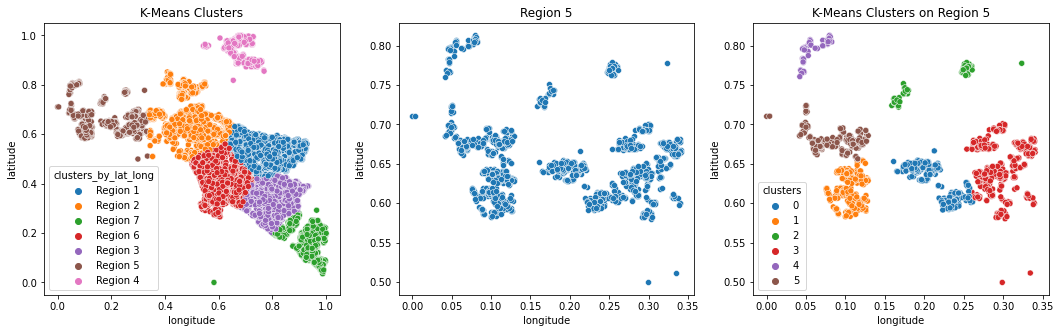

In [167]:
plt.figure(figsize=(18,5))
plt.subplot(131)
sns.scatterplot(data = train_scaled, x = 'longitude', y = 'latitude', hue = 'clusters_by_lat_long', palette = ('tab10'))
plt.title('K-Means Clusters')

plt.subplot(132)
sns.scatterplot(data = Region_5, x = 'longitude', y = 'latitude')
plt.title('Region 5')

plt.subplot(133)
sns.scatterplot(data = Region_5, x = 'longitude', y = 'latitude', hue = 'clusters', palette = ('tab10'))
plt.title('K-Means Clusters on Region 5')

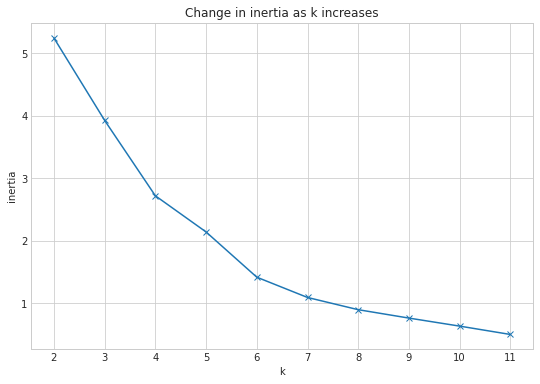

In [168]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [169]:
def map_clusters(df):
     # identified counties for fips codes 
    clusters = {0: 'Region 5A',
                 1: 'Region 5B',
                 2: 'Region 5C',
                 3: 'Region 5D',
                 4: 'Region 5E',
                 5: 'Region 5F',}
     # map clusters 
    df.clusters= df.clusters.map(clusters)
    return df

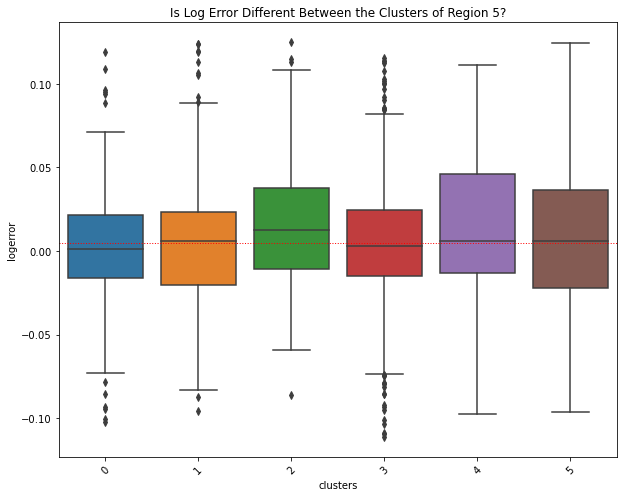

In [170]:
plt.figure(figsize=(10,8))
sns.boxplot(data=Region_5,x='clusters',y='logerror')
plt.title("Is Log Error Different Between the Clusters of Region 5?")
plt.axhline(Region_5.logerror.median(),ls= ':', color = 'red', linewidth=1)
plt.xticks(rotation=45)
plt.show()

In [171]:
map_clusters(Region_5)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,logerror,transactiondate,propertylandusedesc,age,taxvalue_per_sqft,month_of_sale,clusters_by_lat_long,clusters
15866,0.666667,0.666667,0.764300,Ventura,0.622552,0.253926,0.389471,0.857143,0.477680,0.016443,2017-04-05,Single Family Residential,0.142857,0.297980,0.375,Region 5,Region 5A
19839,0.500000,0.333333,0.458251,Ventura,0.641463,0.205512,0.501625,0.795918,0.521938,-0.051815,2017-04-25,Single Family Residential,0.204082,0.493266,0.375,Region 5,Region 5A
48210,0.166667,0.000000,0.214333,Ventura,0.627509,0.105631,0.419180,0.428571,0.185256,0.014229,2017-08-29,Single Family Residential,0.571429,0.289562,0.875,Region 5,Region 5B
44253,0.500000,0.666667,0.464497,Ventura,0.638826,0.265880,0.521853,0.571429,0.624221,-0.006564,2017-08-10,Single Family Residential,0.428571,0.585859,0.875,Region 5,Region 5D
51503,0.500000,0.333333,0.616371,Ventura,0.772859,0.249844,0.394437,0.887755,0.406405,-0.001151,2017-09-13,Single Family Residential,0.112245,0.303030,1.000,Region 5,Region 5C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6976,0.166667,0.333333,0.302761,Ventura,0.799931,0.071119,0.405635,0.438776,0.490772,0.036086,2017-02-16,Single Family Residential,0.561224,0.624579,0.125,Region 5,Region 5E
39384,0.333333,0.666667,0.363905,Ventura,0.673656,0.076542,0.477696,0.428571,0.048294,0.038654,2017-07-18,Single Family Residential,0.571429,0.048822,0.750,Region 5,Region 5F
35379,0.500000,0.666667,0.407955,Ventura,0.678788,0.126590,0.487087,0.857143,0.259025,0.033433,2017-06-29,Single Family Residential,0.142857,0.264310,0.625,Region 5,Region 5F
39201,0.500000,0.666667,0.506903,Ventura,0.629864,0.196524,0.156312,0.928571,0.579743,0.019592,2017-07-17,Single Family Residential,0.071429,0.508418,0.750,Region 5,Region 5A


### Region 5C

In [172]:
Region_5C = Region_5[Region_5.clusters == 'Region 5C']

In [191]:
Region_5C.corr()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,logerror,age,taxvalue_per_sqft,month_of_sale
bathroomcnt,1.000000,0.605877,0.723599,0.198882,0.283347,-0.195728,0.592578,0.475455,-0.097197,-0.592578,0.001907,0.084636
bedroomcnt,0.605877,1.000000,0.574505,0.122691,0.254308,-0.013074,0.343624,0.235125,-0.024424,-0.343624,-0.147172,0.004912
calculatedfinishedsquarefeet,0.723599,0.574505,1.000000,0.289340,0.329782,0.073815,0.543582,0.527973,-0.134435,-0.543582,-0.098307,0.088979
latitude,0.198882,0.122691,0.289340,1.000000,0.945034,-0.052262,0.430593,0.283336,-0.105585,-0.430593,0.115256,0.022707
longitude,0.283347,0.254308,0.329782,0.945034,1.000000,-0.085287,0.450780,0.244933,-0.019870,-0.450780,0.042556,-0.010795
lotsizesquarefeet,-0.195728,-0.013074,0.073815,-0.052262,-0.085287,1.000000,-0.466330,-0.041559,-0.059289,0.466330,-0.090661,0.135165
yearbuilt,0.592578,0.343624,0.543582,0.430593,0.450780,-0.466330,1.000000,0.391304,0.093348,-1.000000,0.037570,-0.078654
taxvaluedollarcnt,0.475455,0.235125,0.527973,0.283336,0.244933,-0.041559,0.391304,1.000000,-0.312151,-0.391304,0.771593,0.116429
logerror,-0.097197,-0.024424,-0.134435,-0.105585,-0.019870,-0.059289,0.093348,-0.312151,1.000000,-0.093348,-0.290846,-0.163735
age,-0.592578,-0.343624,-0.543582,-0.430593,-0.450780,0.466330,-1.000000,-0.391304,-0.093348,1.000000,-0.037570,0.078654


**Notes:**
- Highest correlation values associated with logerror is lotsizesquarefeet, bathroomcnt, bedroomcnt, latitude, age.

#### Modeled on lot size, bathroom count, bedroom count, latitude, and age.

In [174]:
X_train = Region_5C.drop(columns =['fips', 'longitude', 'calculatedfinishedsquarefeet',
                                       'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 'clusters', 'clusters_by_lat_long'])
y_train = Region_5C['logerror']

X_validate = Region_5C.drop(columns =['fips', 'longitude', 'calculatedfinishedsquarefeet',
                                       'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 'clusters', 'clusters_by_lat_long'])
y_validate = Region_5C['logerror']

X_test = Region_5C.drop(columns =['fips', 'longitude', 'calculatedfinishedsquarefeet',
                                       'yearbuilt', 'taxvaluedollarcnt',
                                      'logerror', 'transactiondate', 'propertylandusedesc',
                                       'taxvalue_per_sqft', 'month_of_sale', 'clusters', 'clusters_by_lat_long'])
y_test = Region_5C['logerror']

In [175]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [176]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

In [177]:
# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

In [178]:
# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [179]:
# create the model
lm3 = LinearRegression(normalize=True)

In [180]:
# fit the model
lm3.fit(X_train_degree3, y_train.logerror)

LinearRegression(normalize=True)

In [181]:
# predict train
y_train['LE_pred_lm3'] = lm3.predict(X_train_degree3)

In [182]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.LE_pred_lm3)**(1/2)

In [183]:
# predict validate
y_validate['LE_pred_lm3'] = lm3.predict(X_validate_degree3)

In [184]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.LE_pred_lm3)**(1/2)

In [185]:
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.010295899907968392 
Validation/Out-of-Sample:  0.010295899907968392


### Test the model

In [186]:
y_test = pd.DataFrame(y_test)

In [187]:
# predict test
y_test['LE_pred_lm3'] = lm3.predict(X_test_degree3)

In [188]:
# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.LE_pred_lm3)**(1/2)

In [189]:
print("RMSE for Polynomial Model, degrees=3\nTesting/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=3
Testing/Out-of-Sample:  0.010295899907968392


### Conclusion:
 - Clusters were created geographically, allowing for modeling on smaller geographical areas.
 - Polynomial regression beat baseline in 4 out of 7 counties.
     - Determine the significance level in improvements of models from baseline.
 
- With additional time:
     - Continue exploration on features within regions.
     - Explore different models per region.
     